In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals

#! pip install tensorflow
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# import norm
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.regularizers import l2

# Helper libraries
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.image as mpimg
#import imageio as im

import pandas as pd
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix

AUTOTUNE = tf.data.experimental.AUTOTUNE
import IPython.display as display


import os
from os import listdir
from os.path import isfile, join
import pickle
import random
#importing module
import sys
sys.path.insert(0, '../data')
from datahandler_multilabel import create_dataset

from PIL import ImageFile, Image

import glob

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
with open('../data/train_test_split.pkl', 'rb') as infile:
    train_x, train_y, val_x, val_y, test_x, test_y = pickle.load(infile)

len(train_x), len(train_y), len(val_x), len(val_y), len(test_x), len(test_y)

(18000, 18000, 3000, 3000, 3999, 3999)

In [7]:
file = 'training_flat_multilabelVGG_weight.h5'
model = tf.keras.models.load_model('./results/'+file, compile=False)

In [8]:
def macro_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

def mean_per_class_accuracy(y, y_hat):
    y_pred = tf.cast(tf.greater(y_hat, 0.5), tf.float32)
    per_class_acc = []
    per_class_acc.append(tf.cast(tf.math.count_nonzero(y_pred[i] * y[i], axis=0), tf.float32))
    mean_acc = tf.reduce_mean(per_class_acc)
    return mean_acc

def precision(y, y_hat):
    y_pred = tf.cast(tf.greater(y_hat, 0.5), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    pres = tp / (tp + fp + 1e-16)
    precision = tf.reduce_mean(pres)
    return precision

def recall(y, y_hat):
    y_pred = tf.cast(tf.greater(y_hat, 0.5), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    rec = tp / (tp + fn + 1e-16)
    recall = tf.reduce_mean(rec)
    return recall

In [9]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=["binary_accuracy",
                       "categorical_accuracy",
                       precision,
                       recall,
                       macro_f1
                      ])

In [10]:
train_generator = create_dataset(train_x, train_y)
val_generator = create_dataset(val_x, val_y)
test_generator = create_dataset(test_x, test_y)

In [11]:
model.evaluate(test_generator, verbose=2)

72/72 - 71s - loss: 0.3800 - binary_accuracy: 0.8485 - categorical_accuracy: 0.4381 - precision: 0.5832 - recall: 0.4338 - macro_f1: 0.4746


[0.38002346580227214, 0.8485288, 0.43810952, 0.583154, 0.4338497, 0.47460207]

In [12]:
pred = model.predict_generator(test_generator, verbose=1)

Instructions for updating:
Please use Model.predict, which supports generators.
72/72 [==============================] - 42s 585ms/step


In [73]:
predicted_class_indices = np.where(pred > 0.5, 1, 0)
print(predicted_class_indices)

[[1 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]]


In [74]:
def mean_per_class_accuracy(y, y_hat, num_classes):
    accuracy = [0]*num_classes
    for i in range(num_classes):
        accuracy[i] = 0
        for j in range(len(y)):
            if y[j][i] == y_hat[j][i]:
                accuracy[i] += 1
        accuracy[i] /= len(y)
    return accuracy

def mean_per_item_accuracy(y, y_hat, num_classes):
    accuracy = [0]*len(y)
    for i in range(len(y)):
        accuracy[i] = 0
        for j in range(num_classes):
            if y[i][j] == y_hat[i][j]:
                accuracy[i] += 1
        accuracy[i] /= num_classes
    return sum(accuracy)/len(y)


In [76]:
per_class_accuracy = mean_per_class_accuracy(
    test_y, predicted_class_indices, 15
)
per_class_accuracy, sum(per_class_accuracy)/15

([0.5037222222222222,
  0.5506111111111112,
  0.6143333333333333,
  0.5755,
  0.5785555555555556,
  0.6287222222222222,
  0.5005555555555555,
  0.6303888888888889,
  0.8836111111111111,
  0.7716111111111111,
  0.8683333333333333,
  0.8905,
  0.8925,
  0.9323333333333333,
  0.8826111111111111],
 0.7135925925925926)

In [78]:
per_item_accuracy = mean_per_item_accuracy(
    test_y, predicted_class_indices, 15
)
per_item_accuracy

0.7135925925925849

In [79]:
conf_matrix = multilabel_confusion_matrix(test_y, predicted_class_indices)
print(conf_matrix)

[[[ 3372  4161]
  [ 4772  5695]]

 [[ 8099  3112]
  [ 4977  1812]]

 [[ 9866  3360]
  [ 3582  1192]]

 [[ 8566  3585]
  [ 4056  1793]]

 [[ 8926  3856]
  [ 3730  1488]]

 [[10293  2405]
  [ 4278  1024]]

 [[ 5155  4132]
  [ 4858  3855]]

 [[10314  3284]
  [ 3369  1033]]

 [[15836   903]
  [ 1192    69]]

 [[13596  1492]
  [ 2619   293]]

 [[15556   753]
  [ 1617    74]]

 [[15980   584]
  [ 1387    49]]

 [[16031   366]
  [ 1569    34]]

 [[16762   390]
  [  828    20]]

 [[15822   737]
  [ 1376    65]]]


In [18]:
from sklearn import metrics
precision = metrics.precision_score(test_y, predicted_class_indices, average=None)
recall = metrics.recall_score(test_y, predicted_class_indices, average=None)
f1 = metrics.f1_score(test_y, predicted_class_indices, average=None)
print(precision, '\n', recall, '\n', f1, '\n', sum(precision)/15, '\n', sum(recall)/15, '\n', sum(f1)/15)

[0.56390977 0.36720322 0.25376128 0.3319398  0.28087167 0.3079096
 0.5131291  0.23689727 0.0505618  0.16712329 0.09848485 0.14
 0.08695652 0.07843137 0.08264463] 
 [0.53262317 0.24300932 0.23447637 0.29782446 0.30182134 0.18076285
 0.46481665 0.22398414 0.0323741  0.09355828 0.03412073 0.04416404
 0.01146132 0.01869159 0.03533569] 
 [0.54782013 0.29246795 0.24373796 0.31395809 0.2909699  0.22779519
 0.48777951 0.23025981 0.03947368 0.11996067 0.05068226 0.06714628
 0.02025316 0.03018868 0.04950495] 
 0.23732161239537158 
 0.18326826970816235 
 0.20079988178794117


In [21]:
import sklearn

In [23]:
sklearn.metrics.average_precision_score(test_y, predicted_class_indices, average='weighted')

0.34108420556072794

In [80]:
print(sklearn.metrics.classification_report(train_y, predicted_class_indices))

              precision    recall  f1-score   support

           0       0.58      0.54      0.56     10467
           1       0.37      0.27      0.31      6789
           2       0.26      0.25      0.26      4774
           3       0.33      0.31      0.32      5849
           4       0.28      0.29      0.28      5218
           5       0.30      0.19      0.23      5302
           6       0.48      0.44      0.46      8713
           7       0.24      0.23      0.24      4402
           8       0.07      0.05      0.06      1261
           9       0.16      0.10      0.12      2912
          10       0.09      0.04      0.06      1691
          11       0.08      0.03      0.05      1436
          12       0.09      0.02      0.03      1603
          13       0.05      0.02      0.03       848
          14       0.08      0.05      0.06      1441

   micro avg       0.36      0.29      0.32     62706
   macro avg       0.23      0.19      0.21     62706
weighted avg       0.34   

In [24]:
labels_dict = {0:'people',1:'objects',2:'places',3:'architecture',4:'abstraction',5:'society',\
          6:'nature',7:'emotions, concepts and ideas',8:'interiors',9:'work and occupations', \
          10:'symbols & personifications',11:'religion and belief',12:'leisure and pastimes',\
          13:'history',14:'literature and fiction',15:'group/movement'}
predictions = [[]]*len(predicted_class_indices)
actual = [[]]*len(test_y)
for k in range(len(predicted_class_indices)):
    predictions[k] = []
    actual[k] = []
    for i in range(len(predicted_class_indices[k])):
        if predicted_class_indices[k][i] == 1:
            predictions[k].append(labels_dict[i])
        if test_y[k][i] == 1:
            actual[k].append(labels_dict[i])
            
print(len(predictions), len(actual))

3999 3999


In [68]:
results=pd.DataFrame({"Filename":test_x,
                      "Actual":actual,
                      "Predictions":predictions,
                      })
results.to_csv("./results/results"+file+".csv",index=False)

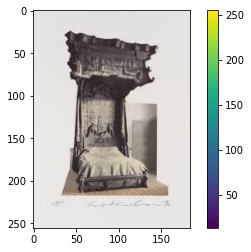

predicted as: ['abstraction', 'emotions, concepts and ideas'] 
actual class: ['objects', 'architecture', 'emotions, concepts and ideas', 'interiors', 'literature and fiction']


In [42]:
number = random.randrange(0, 4000, 1)
results = pd.read_csv("./results/results_Naive_VGG_weight.csv")
img  = Image.open(str(results.Filename[number]))
plt.figure()
plt.imshow(img)
plt.colorbar()
plt.grid(False)
plt.show()
print('predicted as:', results.Predictions[number],
     '\nactual class:', results.Actual[number])

In [2]:
import torch
from CNN_RNN.model_attention import DecoderRNN
model = DecoderRNN(512, 1024, 19, 1).to('cpu')
checkpoint = torch.load('./results/decoder-5-600.ckpt', map_location=torch.device('cpu'))
print(checkpoint.keys())
model.load_state_dict(checkpoint)
model.eval()

odict_keys(['att_bias', 'embed.weight', 'lstm_cell.weight_ih', 'lstm_cell.weight_hh', 'lstm_cell.bias_ih', 'lstm_cell.bias_hh', 'linear.weight', 'linear.bias', 'att_vw.weight', 'att_hw.weight', 'att_w.weight'])


DecoderRNN(
  (embed): Embedding(19, 512)
  (lstm_cell): LSTMCell(1024, 1024)
  (linear): Linear(in_features=1024, out_features=19, bias=True)
  (att_vw): Linear(in_features=512, out_features=512, bias=False)
  (att_hw): Linear(in_features=1024, out_features=512, bias=False)
  (att_w): Linear(in_features=512, out_features=1, bias=False)
)

In [ ]:
import pickle
import numpy as np

with open('./results/predictions_CNN_RNN__.pkl', 'rb') as infile:
    predictions = pickle.load(infile)
reals = []
predicted = []
for key in predictions.keys():
    reals.append(predictions[key][1][0])
    preds = []
    for i in range(len(predictions[key][0][0])):
        preds += [np.argmax(predictions[key][0][0][i])]
    predicted.append(preds)
    
len(predicted), len(reals)

In [ ]:
predicted_class_indices = []
test_y = []

for i in range(len(predicted)):
    predicted_class_indices.append([0]*15)
    test_y.append([0]*15)
    for j in range(len(predicted[i])):
        if predicted[i][j] > 2:
            predicted_class_indices[i][predicted[i][j]-4] = 1
        if reals[i][j] > 2:
            test_y[i][reals[i][j]-4] = 1

predicted_class_indices[:10], test_y[:10]

In [164]:
from sklearn import metrics
precision = metrics.precision_score(test_y, predicted_class_indices, average=None)
recall = metrics.recall_score(test_y, predicted_class_indices, average=None)
f1 = metrics.f1_score(test_y, predicted_class_indices, average=None)
print(precision, '\n', recall, '\n', f1, '\n\n', sum(precision)/15, '\n', sum(recall)/15, '\n', sum(f1)/17)

[0.6525603  0.16666667 0.36785714 0.44106464 0.42528736 0.77667984
 0.57142857 0.5256167  0.43386243 0.72907489 0.39583333 0.16666667
 0.375      0.33187135 0.        ] 
 [0.91242604 0.09174312 0.40077821 0.34117647 0.27086384 0.49217282
 0.02380952 0.7630854  0.28671329 0.32104753 0.27142857 0.00420168
 0.09933775 0.71835443 0.        ] 
 [0.76091784 0.1183432  0.38361266 0.38474295 0.33094812 0.6025297
 0.04571429 0.62247191 0.34526316 0.44579125 0.3220339  0.00819672
 0.15706806 0.454      0.        ] 

 0.42396465931359173 
 0.33314257753377147 
 0.293037279836688


C:\Users\Ludovica\Anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
per_class_accuracy = mean_per_class_accuracy(
    test_y, predicted_class_indices
)
per_class_accuracy, sum(per_class_accuracy)/15

In [76]:
per_item_accuracy = mean_per_item_accuracy(
    test_y, predicted_class_indices, 15
)
per_item_accuracy

0.8229111111111028

In [43]:
print(metrics.classification_report(test_y, predicted_class_indices))

              precision    recall  f1-score   support

           0       0.56      0.53      0.55      2253
           1       0.37      0.24      0.29      1502
           2       0.25      0.23      0.24      1079
           3       0.33      0.30      0.31      1333
           4       0.28      0.30      0.29      1153
           5       0.31      0.18      0.23      1206
           6       0.51      0.46      0.49      2018
           7       0.24      0.22      0.23      1009
           8       0.05      0.03      0.04       278
           9       0.17      0.09      0.12       652
          10       0.10      0.03      0.05       381
          11       0.14      0.04      0.07       317
          12       0.09      0.01      0.02       349
          13       0.08      0.02      0.03       214
          14       0.08      0.04      0.05       283

   micro avg       0.37      0.29      0.32     14027
   macro avg       0.24      0.18      0.20     14027
weighted avg       0.34   

c:\users\marco\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
number = random.randrange(0, 3000, 1)
img = Image.open('../../data_tate/'+ list(predictions.keys())[number])
plt.figure()
plt.imshow(img)
plt.colorbar()
plt.grid(False)
plt.show()

import json
from CNN_RNN.build_vocab import Vocabulary


vocab = ['<pad>', '<start>', '<end>', '<unk>', 'people', 'religion and belief', 'emotions, concepts and ideas', 'work and occupations', 'society', 'nature', 'literature and fiction', 'objects', 'places', 'architecture', 'symbols & personifications', 'leisure and pastimes', 'interiors', 'abstraction', 'history']
print(vocab)   

print('actual class as:', [vocab[int(i)-1] for i in reals[number]],
      '\npredicted as:', [vocab[int(i)-1] for i in predicted[number]])

### Visualizing intermediate activations

In [60]:
layer_outputs = [layer.output for layer in model.get_layer("vgg16").layers] # Extracts the outputs of the top 12 layers
activation_model = tf.keras.models.Model(inputs=model.get_layer("vgg16").get_layer("input_1").input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

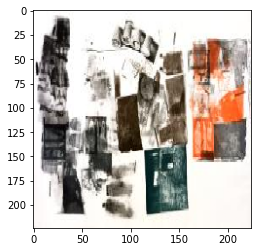

(1, 224, 224, 3)
predicted as: ['people'] 
actual class: ['people', 'objects', 'architecture', 'emotions, concepts and ideas', 'work and occupations', 'history']


In [61]:
number = random.randrange(0, 4000, 1)
results = pd.read_csv("./results/results_Naive_VGG_weight.csv")
#img_path = test_x[number].replace("\\", '/')
img_path  = str(results.Filename[number])
img = image.load_img(img_path, target_size=(224, 224))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
plt.imshow(img_tensor[0])
plt.show()
print(img_tensor.shape)
print('predicted as:', results.Predictions[number],
     '\nactual class:', results.Actual[number])

In [62]:
activations = activation_model.predict(img_tensor) 

In [63]:
first_layer_activation = activations[3]
print(first_layer_activation.shape)

(1, 112, 112, 64)


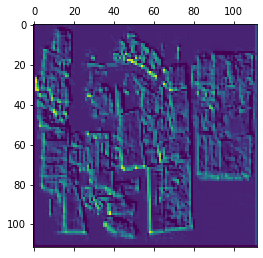

In [64]:
plt.matshow(first_layer_activation[0, :, :, 5], cmap='viridis')

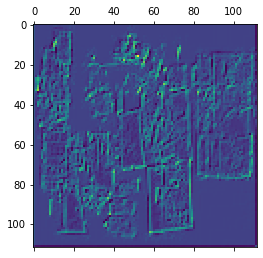

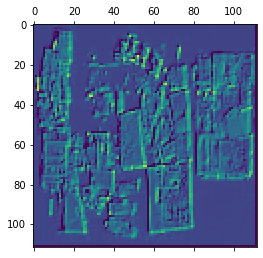

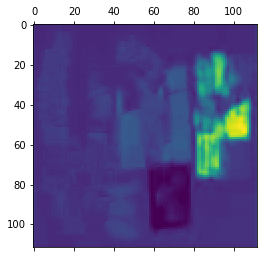

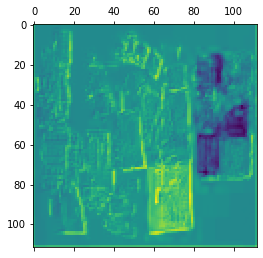

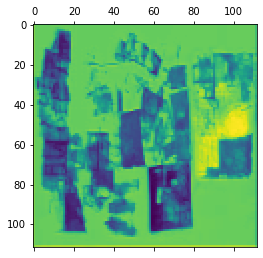

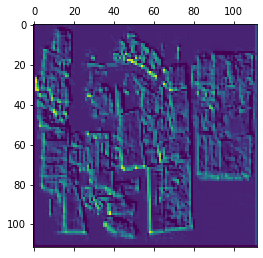

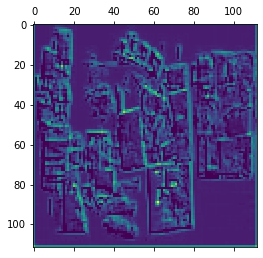

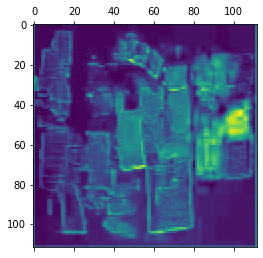

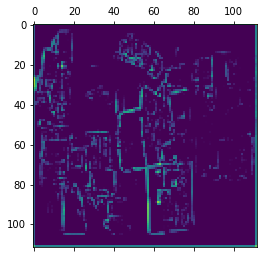

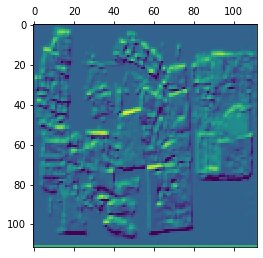

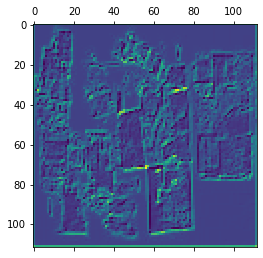

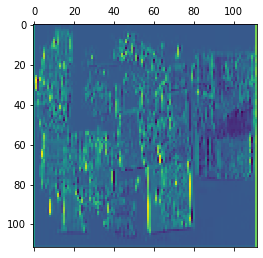

In [65]:
for i in range(12):
    plt.matshow(first_layer_activation[0, :, :, i], cmap='viridis')

In [ ]:
layer_names = []
for layer in model.get_layer("vgg16").layers[:12]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 1

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 224).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [ ]:
from deep_viz_keras.guided_backprop import GuidedBackprop
from tensorflow.keras.utils import *


guided_bprop = GuidedBackprop(model)
number = random.randrange(0, 4000, 1)
img_path = test_x[number].replace("\\", '/')
# Load the image and compute the guided gradient
image = load_image(img_path)
mask = guided_bprop.get_mask(image)               # compute the gradients
show_image(mask) 

#### Results of evalute.py

In [2]:
with open('evals.pkl', 'rb') as infile:
    evals = pickle.load(infile)

evals.keys()

dict_keys(['training_flat_multilabel_ResNetfine_tuned.h5', 'training_flat_multilabel_VGGfine_tuned.h5', 'training_flat_multilabel_InceptionV3fine_tuned.h5', 'training_flat_multilabelVGG.h5', 'training_flat_multilabelInceptionV3.h5', 'training_flat_multilabelResNet.h5'])

### Plotting result records

In [153]:
list_paths = ['training_flat_multilabel_ResNetfine_tuned.csv', \
                  'training_flat_multilabel_VGGfine_tuned.csv', \
                  'training_flat_multilabel_InceptionV3fine_tuned.csv', \
                  'training_flat_multilabel_VGG.csv', \
                  'training_flat_multilabel_InceptionV3.csv', \
                  'training_flat_multilabel_ResNet.csv', \
                  'training_flat_multilabel_VGG_weight.csv', \
                 ]
record_model = {}
for record in list_paths:
    print(record)
    with open('./results/'+ record, 'rb') as infile:
        record_model[record] = pd.read_csv(infile)

training_flat_multilabel_ResNetfine_tuned.csv
training_flat_multilabel_VGGfine_tuned.csv
training_flat_multilabel_InceptionV3fine_tuned.csv
training_flat_multilabel_VGG.csv
training_flat_multilabel_InceptionV3.csv
training_flat_multilabel_ResNet.csv
training_flat_multilabel_VGG_weight.csv


In [154]:
record_model['training_flat_multilabel_VGG.csv']

,epoch,binary_accuracy,categorical_accuracy,loss,macro_f1,precision,recall,val_binary_accuracy,val_categorical_accuracy,val_loss,val_macro_f1,val_precision,val_recall
0,0,0.819563,0.456611,0.410792,0.259689,0.344834,0.238409,0.834067,0.452333,0.388609,0.315855,0.421912,0.275259
1,1,0.833811,0.464111,0.381774,0.319658,0.426153,0.288185,0.839356,0.468333,0.374867,0.337594,0.450543,0.301392
2,2,0.837915,0.465944,0.371603,0.338579,0.447321,0.303668,0.840089,0.463333,0.368067,0.328782,0.451673,0.290134
3,3,0.840311,0.467389,0.365092,0.348888,0.455403,0.313748,0.839156,0.520667,0.368811,0.371424,0.472031,0.335051
4,4,0.843096,0.469889,0.360128,0.361182,0.477771,0.323602,0.843267,0.476333,0.361766,0.370803,0.473659,0.335374
5,5,0.844085,0.473944,0.355648,0.371571,0.487037,0.332350,0.843933,0.445667,0.361055,0.357249,0.466584,0.316661
6,6,0.846304,0.474611,0.351583,0.379031,0.498497,0.339537,0.845400,0.463667,0.357107,0.352880,0.472179,0.314711
7,7,0.847971,0.475389,0.347790,0.388283,0.514598,0.346656,0.845778,0.475333,0.354400,0.370956,0.480870,0.332216
8,8,0.849408,0.474944,0.344522,0.395312,0.522047,0.353234,0.845378,0.474000,0.354413,0.370982,0.490000,0.331729
9,9,0.850618,0.479278,0.341875,0.403935,0.536261,0.359703,0.847889,0.479333,0.351906,0.382115,0.528080,0.332282


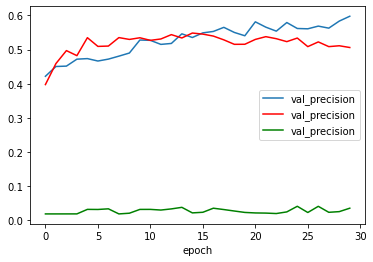

In [155]:
import matplotlib.pyplot as plt

# gca stands for 'get current axis'
ax = plt.gca()

record_model['training_flat_multilabel_VGG.csv'].plot(kind='line',x='epoch',y='val_precision',ax=ax)
record_model['training_flat_multilabel_InceptionV3.csv'].plot(kind='line',x='epoch',y='val_precision', color='red', ax=ax)
record_model['training_flat_multilabel_ResNet.csv'].plot(kind='line',x='epoch',y='val_precision', color='green', ax=ax)

plt.show()

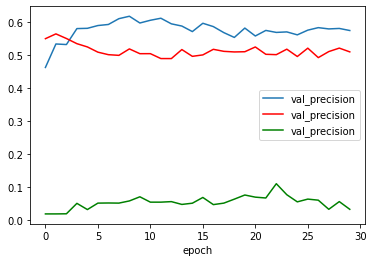

In [156]:
# gca stands for 'get current axis'
ax = plt.gca()

record_model['training_flat_multilabel_VGGfine_tuned.csv'].plot(kind='line',x='epoch',y='val_precision',ax=ax)
record_model['training_flat_multilabel_InceptionV3fine_tuned.csv'].plot(kind='line',x='epoch',y='val_precision', color='red', ax=ax)
record_model['training_flat_multilabel_ResNetfine_tuned.csv'].plot(kind='line',x='epoch',y='val_precision', color='green', ax=ax)

plt.show()

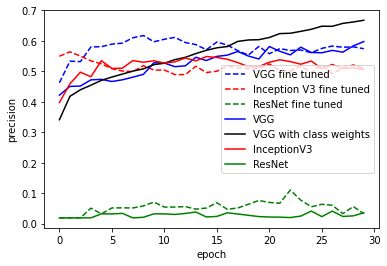

In [159]:
# gca stands for 'get current axis'
ax = plt.gca()
line1 = record_model['training_flat_multilabel_VGGfine_tuned.csv'].plot(kind='line',x='epoch',y='val_precision', color='blue', style='--', ax=ax, label='VGG fine tuned')
line2 = record_model['training_flat_multilabel_InceptionV3fine_tuned.csv'].plot(kind='line',x='epoch',y='val_precision', color='red', style='--', ax=ax, label='Inception V3 fine tuned')
line3 = record_model['training_flat_multilabel_ResNetfine_tuned.csv'].plot(kind='line',x='epoch',y='val_precision', color='green', style='--', ax=ax, label='ResNet fine tuned')
line4 = record_model['training_flat_multilabel_VGG.csv'].plot(kind='line',x='epoch',y='val_precision', color='blue', ax=ax, label='VGG')
line4_ = record_model['training_flat_multilabel_VGG_weight.csv'][:30].plot(kind='line',x='epoch',y='precision', color='black', ax=ax, label='VGG with class weights')
line5 = record_model['training_flat_multilabel_InceptionV3.csv'].plot(kind='line',x='epoch',y='val_precision', color='red', ax=ax, label='InceptionV3')
line6 = record_model['training_flat_multilabel_ResNet.csv'].plot(kind='line',x='epoch',y='val_precision', color='green', ax=ax, label='ResNet')
plt.ylabel('precision')
plt.savefig('./results/precision_plot.png')
plt.show()

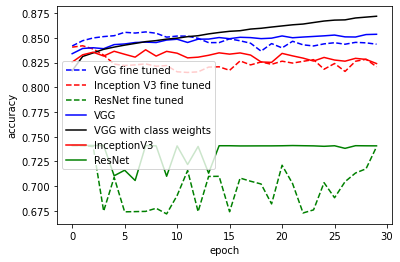

In [160]:
# gca stands for 'get current axis'
ax = plt.gca()
line1 = record_model['training_flat_multilabel_VGGfine_tuned.csv'].plot(kind='line',x='epoch',y='val_binary_accuracy', color='blue', style='--', ax=ax, label='VGG fine tuned')
line2 = record_model['training_flat_multilabel_InceptionV3fine_tuned.csv'].plot(kind='line',x='epoch',y='val_binary_accuracy', color='red', style='--', ax=ax, label='Inception V3 fine tuned')
line3 = record_model['training_flat_multilabel_ResNetfine_tuned.csv'].plot(kind='line',x='epoch',y='val_binary_accuracy', color='green', style='--', ax=ax, label='ResNet fine tuned')
line4 = record_model['training_flat_multilabel_VGG.csv'].plot(kind='line',x='epoch',y='val_binary_accuracy', color='blue', ax=ax, label='VGG')
line4_ = record_model['training_flat_multilabel_VGG_weight.csv'][:30].plot(kind='line',x='epoch',y='binary_accuracy', color='black', ax=ax, label='VGG with class weights')
line5 = record_model['training_flat_multilabel_InceptionV3.csv'].plot(kind='line',x='epoch',y='val_binary_accuracy', color='red', ax=ax, label='InceptionV3')
line6 = record_model['training_flat_multilabel_ResNet.csv'].plot(kind='line',x='epoch',y='val_binary_accuracy', color='green', ax=ax, label='ResNet')
plt.ylabel('accuracy')
plt.savefig('./results/accuracy_plot.png')
plt.show()